In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val
from scipy.optimize import curve_fit

In [2]:
filename = 'data/assorbanza_rodamina_concentrazioni_tot.csv'

header = ['λ 5','I 5','λ 4','I 4','no λ 4','no I 4','λ 3','I 3','λ 2','I 2','λ 1','I 1','λ 0.8','I 0.8','λ 0.6','I 0.6','λ 0.4','I 0.4','λ 0.2','I 0.2','λ 0.1','I 0.1']

data = pd.read_csv(filename,sep=',',header=1,nrows=117)
data = data.iloc[:, :-1] # drop last column
data.columns = header
data.tail()

,λ 5,I 5,λ 4,I 4,no λ 4,no I 4,λ 3,I 3,λ 2,I 2,...,λ 0.8,I 0.8,λ 0.6,I 0.6,λ 0.4,I 0.4,λ 0.2,I 0.2,λ 0.1,I 0.1
112,646.950012,29.311554,646.950012,25.126436,646.950012,29.019300,646.950012,21.187140,646.950012,14.265793,...,646.950012,4.883633,646.950012,3.315377,646.950012,1.589167,646.950012,0.555993,646.950012,0.351009
113,647.969971,28.124762,647.969971,23.946281,647.969971,27.984386,647.969971,20.061258,647.969971,13.714191,...,647.969971,4.719029,647.969971,3.173567,647.969971,1.429973,647.969971,0.563877,647.969971,0.378182
114,648.840027,26.902561,648.840027,23.194933,648.840027,27.167797,648.840027,19.790516,648.840027,13.449127,...,648.840027,4.602462,648.840027,3.138167,648.840027,1.417011,648.840027,0.545661,648.840027,0.333807
115,649.849976,26.203035,649.849976,22.347122,649.849976,25.561733,649.849976,18.675690,649.849976,12.785388,...,649.849976,4.334819,649.849976,2.955356,649.849976,1.345403,649.849976,0.519533,649.849976,0.366366
116,650.859985,24.811270,650.859985,21.325739,650.859985,24.539951,650.859985,18.069601,650.859985,12.159359,...,650.859985,4.134296,650.859985,2.907012,650.859985,1.283329,650.859985,0.497435,650.859985,0.298861


In [3]:
λexc = 526 #nm
C = [5,4,3,2,1,0.8,0.6,0.4,0.2,0.1] #mM

# Extracting the relevant columns for plotting
WAVELENGHTS = ['λ 5', 'λ 4', 'λ 3', 'λ 2', 'λ 1', 'λ 0.8', 'λ 0.6', 'λ 0.4', 'λ 0.2', 'λ 0.1']
INTENSITIES = ['I 5', 'I 4', 'I 3', 'I 2', 'I 1', 'I 0.8', 'I 0.6', 'I 0.4', 'I 0.2', 'I 0.1']
CONCENTRATIONS=[5,4,3,2,1,0.8,0.6,0.4,0.2,0.1]

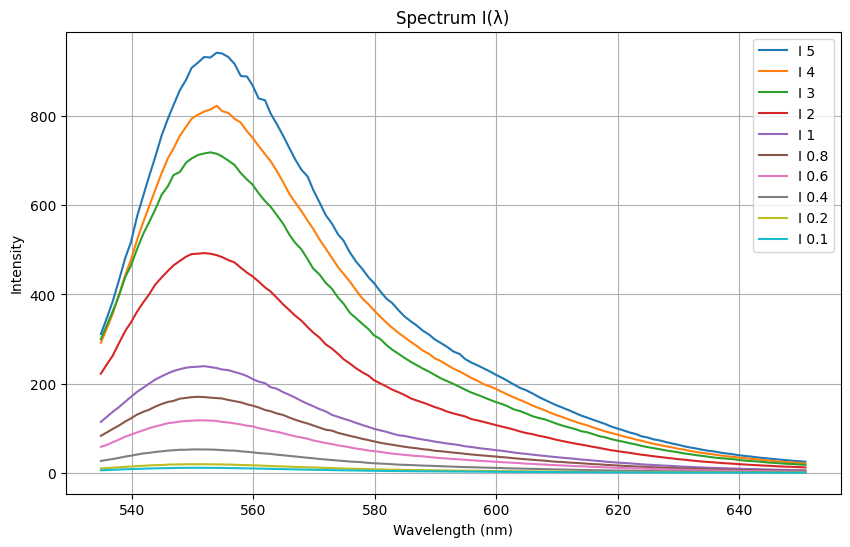

In [4]:
# Plotting the spectrum 
plt.figure(figsize=(10, 6))
for λ_col, I_col in zip(WAVELENGHTS, INTENSITIES):
    plt.plot(data[λ_col], data[I_col],label=f'{I_col}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectrum I(λ)')
plt.legend()
plt.grid()
plt.show()

In [5]:
for λ_col, I_col in zip(WAVELENGHTS, INTENSITIES):
    Λ = data[λ_col]
    I = data[I_col]
    Λmax = Λ[I.idxmax()]
    print(f'λmax {I_col} = {int(np.round(Λmax))} nm')#, {np.mean(np.diff(Λ))} nm')

λmax I 5 = 554 nm
λmax I 4 = 554 nm
λmax I 3 = 553 nm
λmax I 2 = 552 nm
λmax I 1 = 552 nm
λmax I 0.8 = 551 nm
λmax I 0.6 = 551 nm
λmax I 0.4 = 551 nm
λmax I 0.2 = 552 nm
λmax I 0.1 = 551 nm


In [6]:
# making maximum point interpolation:
def max_fit_parabolic(x, λcenter, a, IMAX): # -a*(x-λcenter)**2 + IMAX
    return -a*(x-λcenter)**2 + IMAX

segue fit parabolico dei picchi dello spettro, vengono considerati solo i 5 punti a destra e 5 a sinistra del punto massimo dello spettro

segue l'estrapolazione del valore di Imax

In [7]:
λcenter_list = []
a_list = []
IMAX_list = []
error_λcenter_list = []
error_a_list = []
error_IMAX_list = []
for λ_col, I_col in zip(WAVELENGHTS, INTENSITIES):
    Λ = data[λ_col]
    I = data[I_col]
    Λmaxcenter = I.idxmax()

    λcenter = Λ[Λmaxcenter] # guess
    IMAX = I.max() # guess
    a = 1 # guess

    xrangemax = Λ[Λmaxcenter-5:Λmaxcenter+5] # 10 points around the max
    yrangemax = I[Λmaxcenter-5:Λmaxcenter+5] # 10 points around the max
    popt, pcov = curve_fit(max_fit_parabolic, xrangemax, yrangemax, p0=[λcenter, a, IMAX])
    λcenter, a, IMAX = popt
    error_λcenter, error_a, error_IMAX = np.sqrt(np.diag(pcov))
    λcenter_list.append(λcenter)
    a_list.append(a)
    IMAX_list.append(IMAX)
    error_λcenter_list.append(error_λcenter)
    error_a_list.append(error_a)
    error_IMAX_list.append(error_IMAX)

max_fit_parabolic_dataframe = pd.DataFrame({'Concentration (μM)': CONCENTRATIONS, 'λcenter': λcenter_list, 'a': a_list, 'IMAX': IMAX_list, 'error_λcenter': error_λcenter_list, 'error_a': error_a_list, 'error_IMAX': error_IMAX_list})
display(max_fit_parabolic_dataframe)


,Concentration (μM),λcenter,a,IMAX,error_λcenter,error_a,error_IMAX
0,5.0,553.687884,2.584687,941.083544,0.101127,0.201602,2.215676
1,4.0,553.603998,1.804624,816.883841,0.103584,0.145873,1.605726
2,3.0,552.768769,1.740252,718.429831,0.061279,0.081428,0.886335
3,2.0,551.921469,1.078718,493.252062,0.058392,0.045953,0.498940
4,1.0,551.460400,0.469900,238.421474,0.088408,0.032901,0.361620
5,0.8,551.465957,0.376023,170.299117,0.133564,0.030863,0.321752
6,0.6,551.248264,0.240613,117.722462,0.088322,0.014202,0.150391
7,0.4,551.048687,0.103726,52.558216,0.102621,0.007628,0.081727
8,0.2,550.901888,0.032328,19.328205,0.135248,0.003242,0.035318
9,0.1,551.025060,0.025576,11.340265,0.223187,0.004122,0.044214


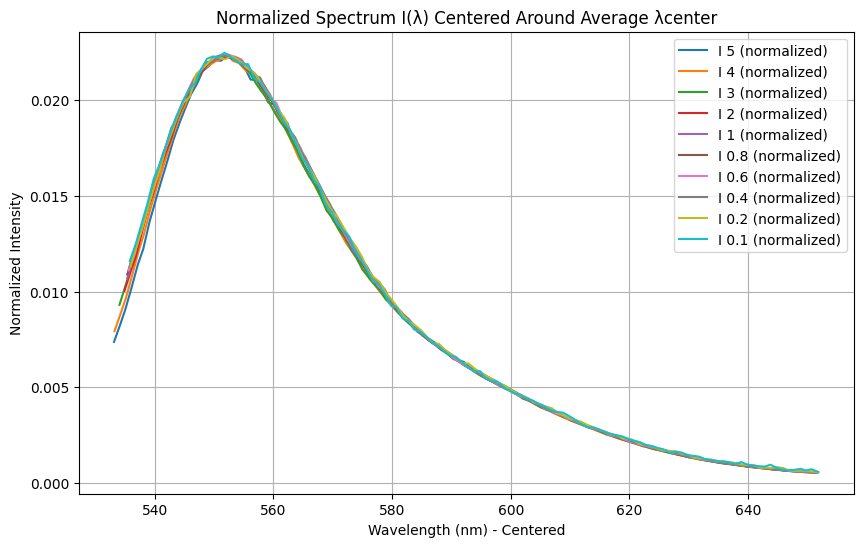

In [8]:
# plotting normalized spectrum (kind of, in the sense that we are not normalizing the area under the curve, but the maximum value of the spectrum)

delta = np.array(λcenter_list) - np.mean(λcenter_list)  # Calculate the average value of λcenter

plt.figure(figsize=(10, 6))
for λ_col, I_col,d in zip(WAVELENGHTS, INTENSITIES, delta):
    area_under_curve = np.trapezoid(data[I_col], data[λ_col])  # Calculate the area under the curve
    centered_wavelengths = data[λ_col] - d  # Center the wavelengths around the average λcenter
    plt.plot(centered_wavelengths, data[I_col] / area_under_curve, label=f'{I_col} (normalized)')
    
plt.xlabel('Wavelength (nm) - Centered')
plt.ylabel('Normalized Intensity')
plt.title('Normalized Spectrum I(λ) Centered Around Average λcenter')
plt.legend()
plt.grid()
plt.show()

In [18]:
# fit with the exponential 1-exp(-k*C)

def F_C_fit(C,F0,k,y0):
    return F0*(1-np.exp(-k*C)) + y0

F0: 1462.576263733457, k: 0.2329793100946648


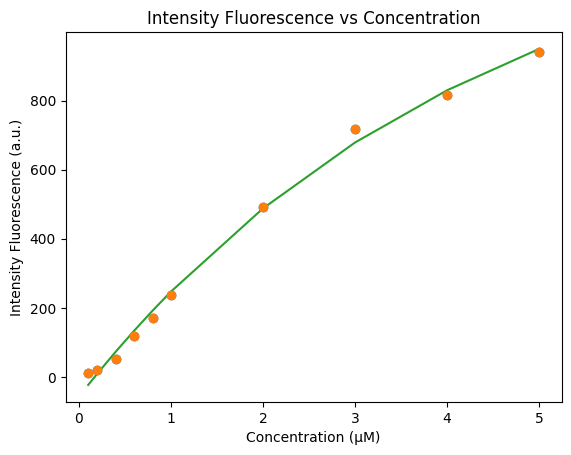

In [22]:
start = 0
I = np.array(IMAX_list)[start:]
sigmaI = np.array(error_IMAX_list)[start:]
C = np.array(CONCENTRATIONS)[start:]

# Fit the data to the model
popt, pcov = curve_fit(F_C_fit, C, I, p0=[1899,0.14,-1.0],maxfev = 6000)
F0, k, y0 = popt
print(f'F0: {F0}, k: {k}')
error_F0, error_k, error_y0 = np.sqrt(np.diag(pcov))

plt.plot(C,I,'o',label='data')
plt.errorbar(C,I,yerr=sigmaI,fmt='o')
plt.plot(C,F_C_fit(C,*popt),label='fit')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Concentration (μM)')
plt.ylabel('Intensity Fluorescence (a.u.)')
plt.title('Intensity Fluorescence vs Concentration')
plt.show()